In [105]:
import numpy as np
import pandas as pd
import os

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['lines.linewidth'] = 2
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['ytick.labelsize'] = 16
matplotlib.rcParams['axes.labelsize'] = 20
matplotlib.rcParams['axes.titlesize'] = 20

%matplotlib inline

plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split

import skimage.io
from skimage.transform import resize

from tqdm import tqdm_notebook

In [2]:
### Here we load in all the relevant neural network packages ###
import tensorflow as tf

# from keras.applications import xception, vgg16, vgg19, mobilenet
# from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.models import Model
from keras import optimizers
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, Input, concatenate, Conv2DTranspose, BatchNormalization
from keras.layers.core import Dense, Dropout, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
# from keras.utils import np_utils, multi_gpu_model
# from keras.optimizers import SGD, Adam
# from keras.datasets import mnist
from keras import backend as K
# from keras import applications
from keras.preprocessing.image import ImageDataGenerator

/home/paperspace/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [465]:
def filter_directory_list(directorylisting):
    if '.DS_Store' in directorylisting:
        directorylisting.remove('.DS_Store')
    return directorylisting

def IoU(x,y):
    '''
    version of IoU that uses np.bincount to get the value counts
    
    x and y are both numpy N x M masks
    
    x = proposed mask
    y = ground truth mask
    
    0 for a pixel indicates the mask is blocked, 1 indicates the mask is not blocked.
    In plain English, everywhere that is 1 we can see the cell, everywhere that is 0 we cannot.
    
    We want to calculate the IoU statistic, which is intersection(x,y)/union(x,y) at values where x or y is 1 
    
    By subtracting the proposed mask from 2 x the ground truth mask (i.e. blocked is 0, not blocked is 2),
    then adding 1, we get unique values for each type of overlap situation, plus all values are positive, which
    is required to use np.bincount:
    
INDX  0  1  2  3  4  5  6  7  8  9 10 11

GT    0  0  0  2  2  2  2  2  0  0  0  0
MSK - 0  0  1  1  1  1  0  1  1  0  0  0  
      ----------------------------------
      0  0 -1  1  1  1  2  1 -1  0  0  0
    + 1  1  1  1  1  1  1  1  1  1  1  1
      ----------------------------------
      1  1  0  2  2  2  3  2  0  1  1  1
      
    0: the proposed mask had a pixel, ground truth did not (include in union)   
    1: neither mask had a pixel (don't include)
    2: the proposed mask had a pixed, the ground truth had a pixel (include in intersection and union)
    3: the proposed mask did not have a pixel, the ground truth did (include in union)
    
    np.bincount always has length of np.amax(x) + 1, so we just need to do length checking
    '''
    x = x
    y = y * 2
    
    diff = np.bincount((y - x + 1).flatten())
    diff_len = len(diff)
    
    ### Cacluate the intersection first
    intersection = 0
    if (diff_len >= 3):
        intersection = diff[2]
    
    ### Now calculate the union
    union = intersection
    if diff_len == 4:
        union += diff[3]
    union += diff[0]
        
    if union==0:
        iou = 0 ### default value, we could potentially return blank masks, although GT should never be empty
    else:
        iou = float(intersection) / union

    return iou

def pred_to_binary_mask(pred, threshold):
    tst = np.zeros((pred.shape[0],pred.shape[1]), dtype=np.int8)
    tst[pred >= threshold] = 1
    return tst
    
def calc_iou(pred, gt, threshold):
    pred_mask = pred_to_binary_mask(pred, threshold)
    if (pred_mask.sum()==0) and (gt.sum()==0):
        IoU_value = 1
    elif pred.sum==0 and mask.sum()!=0:
        IoU_value = 0
    else:
        IoU_value = IoU(pred_mask,gt)
    return IoU_value

def calc_avg_precision(pred_mask, gt_mask, threshold, iou_thresholds=[0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]):
    ### First calculate the IoU matrix
    iou = calc_iou(pred_mask, gt_mask, threshold)
    
    avg_precision = (iou_thresholds < iou).sum() / len(iou_thresholds)
        
    return avg_precision

class TTA_ModelWrapper():
    """A simple TTA wrapper for keras computer vision models.
    Args:
        model (keras model): A fitted keras model with a predict method.
    """

    def __init__(self, model):
        self.model = model

    def predict(self, X):
        """Wraps the predict method of the provided model.
        Augments the testdata with horizontal and vertical flips and
        averages the results.
        Args:
            X (numpy array of dim 4): The data to get predictions for.
        """

        pred = []
        for x_i in tqdm_notebook(X):
            tmp = x_i
            p0 = self.model.predict(tmp.reshape(1,64,64,1))
            p1 = self.model.predict(np.fliplr(tmp).reshape(1,64,64,1))
#             p2 = self.model.predict(np.flipud(tmp).reshape(1,128,128,1))
#             p3 = self.model.predict(np.fliplr(np.flipud(tmp)).reshape(1,128,128,1))
            p = (p0[0] +
                 np.fliplr(p1[0]) #+
#                  np.flipud(p2[0]) +
#                  np.fliplr(np.flipud(p3[0]))
                 ) / 2#4
            pred.append(p)
        return np.array(pred)
    
class TTA_ModelWrapper_3channel():
    """A simple TTA wrapper for keras computer vision models.
    Args:
        model (keras model): A fitted keras model with a predict method.
    """

    def __init__(self, model):
        self.model = model

    def predict(self, X):
        """Wraps the predict method of the provided model.
        Augments the testdata with horizontal and vertical flips and
        averages the results.
        Args:
            X (numpy array of dim 4): The data to get predictions for.
        """

        pred = []
        for x_i in tqdm_notebook(X):
            tmp = x_i
            p0 = self.model.predict(tmp.reshape(1,128,128,3))
            p1 = self.model.predict(np.fliplr(tmp).reshape(1,128,128,3))
#             p2 = self.model.predict(np.flipud(tmp).reshape(1,128,128,1))
#             p3 = self.model.predict(np.fliplr(np.flipud(tmp)).reshape(1,128,128,1))
            p = (p0[0] +
                 np.fliplr(p1[0]) #+
#                  np.flipud(p2[0]) +
#                  np.fliplr(np.flipud(p3[0]))
                 ) / 2#4
            pred.append(p)
        return np.array(pred)

def load_image(path):
    img = skimage.io.imread(path, as_grey=True)
    return img

def load_mask(path):
    mask = skimage.io.imread(path, as_grey=True)
    mask = mask / 65535
    return mask

def biggenate(x):
    target_image_size = (64,64,1)
    return resize(x, target_image_size, mode='constant', preserve_range=True)

def smallenate(x):
    target_image_size = (101,101)
    return resize(x, target_image_size, mode='constant', preserve_range=True)

# def biggenate_zero_pad(x):
#     target_image_size = (128,128,1)
#     new_image = np.zeros((target_image_size[0], target_image_size[1], target_image_size[2]), dtype=np.float64)
#     new_image[13:114,13:114, 0] = x
#     return new_image

def biggenate_zero_pad(x):
    new_img = np.zeros((64,64,1))
    x_ch1, x_ch2 = x.shape
    s = 7
    new_img[s:s+x_ch1,s:s+x_ch2,0] = x
    return new_img

def smallenate_zero_pad(x):
    new_image = x[13:114,13:114]
    return new_image

class LearningRateHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
       self.lr = []
 
    def on_epoch_end(self, batch, logs={}):
       self.lr.append(K.eval(self.model.optimizer.lr))

def write_submission_file(submission_file, preds_test_masks, good_test_images):
    with(open(submission_file,'w')) as f:
        f.write('id,rle_mask')

        for i in tqdm_notebook(range(len(good_test_images))):
            image_name = good_test_images[i].split('.')[0]
            pred_mask = preds_test_masks[i,:,:]
            if pred_mask.sum()==0:
                f.write('\n')
                f.write(image_name + ',')
            elif images_test_orig[i].sum()==0:
                f.write('\n')
                f.write(image_name + ',')
            else:
                pred_mask_rle = mask_to_rle(pred_mask)
                f.write('\n')
                f.write(image_name + ',' + ' '.join(list(pred_mask_rle.astype('str'))))

def chop_up_images(image_set):
    dummy_output = []
    for img in image_set:
        tst_1 = img[0:50,0:50]
        tst_2 = img[0:50,50:]
        tst_3 = img[50:,0:50]
        tst_4 = img[50:,50:]

        tst_1 = biggenate_zero_pad(tst_1)
        tst_2 = biggenate_zero_pad(tst_2)
        tst_3 = biggenate_zero_pad(tst_3)
        tst_4 = biggenate_zero_pad(tst_4)

        dummy_output.append(tst_1)
        dummy_output.append(tst_2)
        dummy_output.append(tst_3)
        dummy_output.append(tst_4)
    dummy_output = np.array(dummy_output)
    return dummy_output

def isvert(mask):
    mask = mask.squeeze()
    vertuni = np.unique(mask.sum(axis=1))
    vertlen = len(np.unique(mask.sum(axis=1)))
    if ((vertlen==1) and (vertuni[0]!=0) and (vertuni[0]!=101)):
        return True
    else:
        return False
    
def reassemble_chopped(x1, x2, x3, x4):
    result = np.zeros((101,101))
    result[0:50,0:50] = x1[7:7+50,7:7+50]
    result[0:50,50:] = x2[7:7+50,7:7+51]
    result[50:,0:50] = x3[7:7+51,7:7+50]
    result[50:,50:] = x4[7:7+51,7:7+51]
    return result

### Load in the training/validation data

In [466]:
### Load in the whole list then eliminate those that are bad ###
traindir = '../../../train/'
all_image_files = np.array(os.listdir(filter_directory_list(traindir + 'images/')))

good_training_images = all_image_files

### Load in the images ###
images_orig = np.array([load_image(traindir + 'images/' + x) for x in tqdm_notebook(good_training_images)])
masks_orig = np.array([load_mask(traindir + 'masks/' + x) for x in tqdm_notebook(good_training_images)])

In [474]:
mask_isnt_vertical_indices = [not isvert(x) for x in masks_orig]

In [475]:
pd.Series(mask_isnt_vertical_indices).value_counts()

True     3887
False     113
dtype: int64

In [476]:
images_orig = images_orig[mask_isnt_vertical_indices]
masks_orig = masks_orig[mask_isnt_vertical_indices]

In [477]:
images_orig.shape, masks_orig.shape

((3887, 101, 101), (3887, 101, 101))

In [478]:
### Run this to mean center the images ###
images_orig = np.array([x - x.mean() for x in images_orig])

In [479]:
### Calculate the mask coverage to do stratified sampling ###
### Find the area of the grid ###
area = masks_orig.shape[1] * masks_orig.shape[2]

### Find the fractional covereage of each mask (they are already normalized to [0,1]) ###
coverage = masks_orig.sum(axis=(1,2)) / area

### Cast into a category every 0.1 coverage. 0 coverage gets its own class too ###
coverage_category = np.ceil(coverage * 10)

In [480]:
low_coverage_limit = 0.2
low_coverage_indices = np.argwhere((coverage <= low_coverage_limit) & (coverage!=0)).squeeze()
# low_coverage_indices = np.argwhere(coverage <= low_coverage_limit).squeeze()

In [481]:
images_orig = images_orig[low_coverage_indices]
masks_orig = masks_orig[low_coverage_indices]
coverage = coverage[low_coverage_indices]
coverage_category = coverage_category[low_coverage_indices]

In [482]:
images_orig.shape, masks_orig.shape

((856, 101, 101), (856, 101, 101))

In [483]:
train_images_orig, \
val_images_orig, \
train_masks_orig, \
val_masks_orig, \
train_coverage, \
val_coverage, \
train_coverage_category, \
val_coverage_category = train_test_split(images_orig, masks_orig, coverage, coverage_category, stratify=coverage_category,test_size=0.2, random_state=42)

#### We need to subdivide the images now into their smaller subsets. The theory is that this creates a better ratio of coverage, which the model can deal with a bit better. We are testing this though.

In [484]:
train_images = chop_up_images(train_images_orig)
val_images = chop_up_images(val_images_orig)
train_masks = chop_up_images(train_masks_orig)
val_masks = chop_up_images(val_masks_orig)

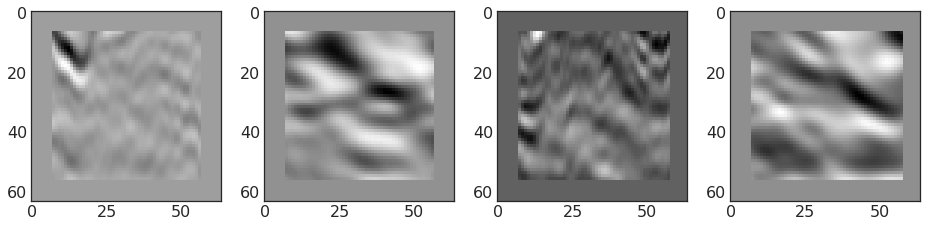

In [485]:
plt.figure(figsize=(16,3.5))
plt.subplot(1,4,1); 
plt.imshow(train_images[8,:,:,0], cmap='gray')
# plt.imshow(train_masks[8,:,:,0], alpha=0.2)
plt.subplot(1,4,2); 
plt.imshow(val_images[8,:,:,0], cmap='gray')
plt.subplot(1,4,3); 
plt.imshow(train_images[9,:,:,0], cmap='gray')
plt.subplot(1,4,4); 
plt.imshow(val_images[9,:,:,0], cmap='gray')

### Produce the UNet model

In [486]:
def unet_model(filter_scaling=16, depth=5, batch_norm_momentum=0.6):

    input_layer = Input((64,64,1))

    conv_initialization_dict = {"activation":'relu', 
                                "padding":'same',
                                "kernel_initializer" : 'he_normal'}

    conv_initialization_dict_no_activation = {"padding":'same',
                                "kernel_initializer" : 'he_normal'}

    conv_dict = {}
    for i in range(1,depth):
        if i==1:
            x = Conv2D((2**(i-1)) * filter_scaling, (3,3), **conv_initialization_dict_no_activation)(input_layer)
        else:
            x = Conv2D((2**(i-1)) * filter_scaling, (3,3), **conv_initialization_dict_no_activation)(x)
        x = Activation('relu')(x)     
        x = BatchNormalization(momentum=batch_norm_momentum)(x)
    #     x = Dropout(0.2)(x)
    #     x = Dropout(0.25)(x)
        conv_dict[i] = Conv2D((2**(i-1)) * filter_scaling, (3,3), **conv_initialization_dict_no_activation)(x)
        x = Activation('relu')(x)
        x = BatchNormalization(momentum=batch_norm_momentum)(x)
    #     x = Dropout(0.2)(x)

        x = MaxPooling2D((2,2), padding='same')(conv_dict[i])


    ### The bottom of the network ###
    x = Conv2D((2**(depth-1)) * filter_scaling, (3,3), **conv_initialization_dict)(x)
    x = BatchNormalization(momentum=batch_norm_momentum)(x)
    x = Conv2D((2**(depth-1)) * filter_scaling, (3,3), **conv_initialization_dict)(x)
    x = BatchNormalization(momentum=batch_norm_momentum)(x)

    for i in range(depth-1,0,-1):

        x = Conv2DTranspose((2**(i-1)) * filter_scaling, (3,3), strides=(2,2), **conv_initialization_dict)(x)
        x = concatenate([conv_dict[i], x])
        x = BatchNormalization(momentum=batch_norm_momentum)(x)
        x = Conv2D((2**(i-1)) * filter_scaling, (3,3), **conv_initialization_dict)(x)
        x = BatchNormalization(momentum=batch_norm_momentum)(x)
    #     x = Dropout(0.2)(x)
        x = Conv2D((2**(i-1)) * filter_scaling, (3,3), **conv_initialization_dict)(x)
        if i!=1:
            x = BatchNormalization(momentum=batch_norm_momentum)(x)
    #         x = Dropout(0.2)(x)

    output_layer = Conv2D(1, (1,1), activation='sigmoid', padding='same')(x)

    model = Model(input_layer, output_layer)

    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

    return model

# model.summary()

In [487]:
model = unet_model(filter_scaling=48, depth=5, batch_norm_momentum=0.6)

In [488]:
batch_size = 64

generator_dict = {'horizontal_flip': True}

image_datagen = ImageDataGenerator(**generator_dict)
mask_datagen = ImageDataGenerator(**generator_dict)

image_generator = image_datagen.flow(
        train_images,
        batch_size=batch_size,
        seed=1)

mask_generator = mask_datagen.flow(
        train_masks,
        batch_size=batch_size,
        seed=1)

combined_generator = zip(image_generator, mask_generator)

In [489]:
model_file = "./unet_models/unet_low_coverage_limit_0.2_no_0s_novertmasks_1"
if os.path.exists(model_file):
    raise ValueError("Model file already exists")

### Set up model training parameters ###
early_stopping = EarlyStopping(patience=12, verbose=1)
model_checkpoint = ModelCheckpoint(model_file, save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.2, patience=3, min_lr=1e-6, verbose=1)
learning_rec= LearningRateHistory()
        
history = model.fit_generator(combined_generator, train_images.shape[0] // batch_size, \
                                      epochs=200, verbose=1, validation_data=(val_images, val_masks),
                                      callbacks=[early_stopping, model_checkpoint, reduce_lr, learning_rec])

Epoch 1/200
42/42 [==============================] - 20s 466ms/step - loss: 0.1788 - acc: 0.9404 - val_loss: 0.1195 - val_acc: 0.9618

Epoch 00001: val_loss improved from inf to 0.11948, saving model to ./unet_models/unet_low_coverage_limit_0.2_no_0s_novertmasks_1
Epoch 2/200
42/42 [==============================] - 10s 245ms/step - loss: 0.1048 - acc: 0.9655 - val_loss: 0.1280 - val_acc: 0.9584

Epoch 00002: val_loss did not improve
Epoch 3/200
42/42 [==============================] - 10s 244ms/step - loss: 0.0944 - acc: 0.9682 - val_loss: 0.0851 - val_acc: 0.9724

Epoch 00003: val_loss improved from 0.11948 to 0.08509, saving model to ./unet_models/unet_low_coverage_limit_0.2_no_0s_novertmasks_1
Epoch 4/200
42/42 [==============================] - 10s 243ms/step - loss: 0.0783 - acc: 0.9733 - val_loss: 0.1261 - val_acc: 0.9522

Epoch 00004: val_loss did not improve
Epoch 5/200
42/42 [==============================] - 10s 246ms/step - loss: 0.0803 - acc: 0.9722 - val_loss: 0.0865 - va

In [490]:
### Load back in the best model ###
model_to_load = model_file
model.load_weights(model_to_load)

################################################################################
### Print out the history to file #############################################
##############################################################################
df = pd.DataFrame()
df['epoch'] = history.epoch
df['loss'] = history.history['loss']
df['acc'] = history.history['acc']
df['val_loss'] = history.history['val_loss']
df['val_acc'] = history.history['val_acc']
df['lr'] = learning_rec.lr
df.to_csv(model_file+'_history.csv',index=False)

###############################################################################
### Extract best parameters ##################################################
#############################################################################
highest_val_acc = history.history['val_acc'][np.argmax(history.history['val_acc'])]
lowest_val_loss = history.history['val_loss'][np.argmin(history.history['val_loss'])]

highest_val_acc, lowest_val_loss

(0.9841411515723827, 0.04863550739232884)

In [491]:
# # model_file = "./unet_models/unet_low_coverage_limit_0.2_1"
# ### Load back in the best model ###
# model_to_load = model_file
# model.load_weights(model_to_load)

In [492]:
###############################################################################
### Do prediction without augmentation #######################################
#############################################################################

preds = model.predict(val_images)

preds = preds.squeeze()

In [493]:
preds.shape, val_images[0].shape

((688, 64, 64), (64, 64, 1))

In [494]:
def reassemble_chopped(x1, x2, x3, x4):
    result = np.zeros((101,101))
    result[0:50,0:50] = x1[7:7+50,7:7+50]
    result[0:50,50:] = x2[7:7+50,7:7+51]
    result[50:,0:50] = x3[7:7+51,7:7+50]
    result[50:,50:] = x4[7:7+51,7:7+51]
    return result

In [495]:
preds_orig = []
for i in range(len(val_images)//4):
    img1 = preds[4*i + 0]
    img2 = preds[4*i + 1]
    img3 = preds[4*i + 2]
    img4 = preds[4*i + 3]
    preds_orig.append(reassemble_chopped(img1, img2, img3, img4))
preds_orig = np.array(preds_orig)

In [496]:
# val_recon = []
# for i in range(len(val_images)//4):
#     img1 = preds[4*i + 0]
#     img2 = preds[4*i + 1]
#     img3 = preds[4*i + 2]
#     img4 = preds[4*i + 3]
#     preds_orig.append(reassemble_chopped(img1, img2, img3, img4))
# preds_orig = np.array(preds_orig)

In [497]:
preds_orig.shape, val_masks.shape

((172, 101, 101), (688, 64, 64, 1))

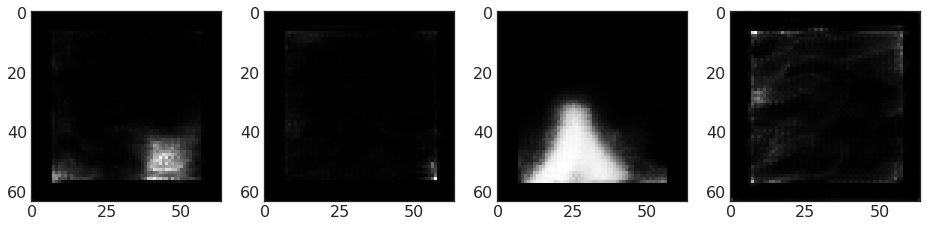

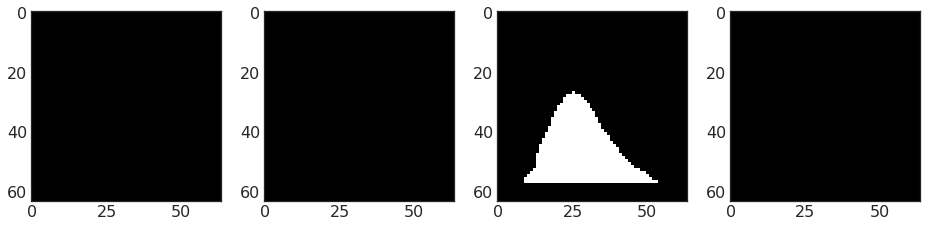

In [498]:
plt.figure(figsize=(16,3.5))
plt.subplot(1,4,1); 
plt.imshow(preds[0,:,:], cmap='gray')
plt.subplot(1,4,2); 
plt.imshow(preds[1,:,:], cmap='gray')
plt.subplot(1,4,3); 
plt.imshow(preds[2,:,:], cmap='gray')
plt.subplot(1,4,4); 
plt.imshow(preds[3,:,:], cmap='gray')

plt.figure(figsize=(16,3.5))
plt.subplot(1,4,1); 
plt.imshow(val_masks[0,:,:,0], cmap='gray')
plt.subplot(1,4,2); 
plt.imshow(val_masks[1,:,:,0], cmap='gray')
plt.subplot(1,4,3); 
plt.imshow(val_masks[2,:,:,0], cmap='gray')
plt.subplot(1,4,4); 
plt.imshow(val_masks[3,:,:,0], cmap='gray')

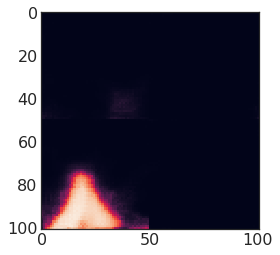

In [499]:
plt.imshow(preds_orig[0])

In [500]:
# def biggenate_zero_pad(x):
#     new_img = np.zeros((64,64,1))
#     x_ch1, x_ch2 = x.shape
#     s = 7
#     new_img[s:s+x_ch1,s:s+x_ch2,0] = x
#     return new_img

In [501]:
thresholds = np.linspace(0, 1.0, 50)
iou_thresholds = np.array([0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95])

mAPs = []
for threshold in tqdm_notebook(thresholds):
    APs = []
    for i in range(len(preds_orig)):
        image = val_images_orig[i]
        ### Need this if/else if you eliminated samples with sum()==0
        if image.sum()==0:
            pred = np.zeros((101,101))
            mask = val_masks_orig[i].squeeze().astype(np.int8)

            AP = calc_avg_precision(pred, mask, threshold, iou_thresholds=iou_thresholds)
        else:
            pred = preds_orig[i]
            mask = val_masks_orig[i].squeeze().astype(np.int8)

            AP = calc_avg_precision(pred, mask, threshold, iou_thresholds=iou_thresholds)

        APs.append(AP)

    mAPs.append(np.mean(APs))

threshold_max = thresholds[np.argmax(mAPs)]
mAP_max = mAPs[np.argmax(mAPs)]

In [502]:
threshold_max, mAP_max

(0.3061224489795918, 0.4279069767441861)

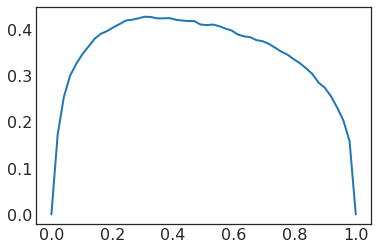

In [503]:
plt.plot(thresholds, mAPs)

Is there a better threshold for only class 1?

In [504]:
class_1_indices = np.argwhere(val_coverage_category == 1).squeeze()
val_images_orig_cov_class_1 = val_images_orig[class_1_indices]
val_masks_orig_cov_class_1 = val_masks_orig[class_1_indices]
preds_orig_class_1 = preds_orig[class_1_indices]

In [505]:
thresholds = np.linspace(0, 1.0, 50)
iou_thresholds = np.array([0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95])

mAPs = []
for threshold in tqdm_notebook(thresholds):
    APs = []
    for i in range(len(preds_orig_class_1)):
        image = val_images_orig_cov_class_1[i]
        ### Need this if/else if you eliminated samples with sum()==0
        if image.sum()==0:
            pred = np.zeros((101,101))
            mask = val_masks_orig_cov_class_1[i].squeeze().astype(np.int8)

            AP = calc_avg_precision(pred, mask, threshold, iou_thresholds=iou_thresholds)
        else:
            pred = preds_orig_class_1[i]
            mask = val_masks_orig_cov_class_1[i].squeeze().astype(np.int8)

            AP = calc_avg_precision(pred, mask, threshold, iou_thresholds=iou_thresholds)

        APs.append(AP)

    mAPs.append(np.mean(APs))

threshold_max_class_1 = thresholds[np.argmax(mAPs)]
mAP_max_class_1 = mAPs[np.argmax(mAPs)]

In [506]:
threshold_max_class_1, mAP_max_class_1

(0.3061224489795918, 0.3356521739130435)

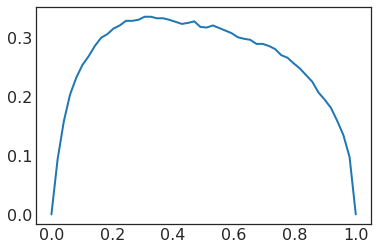

In [507]:
plt.plot(thresholds, mAPs)

In [508]:
preds_val_masks = np.array([pred_to_binary_mask(x, threshold_max) for x in tqdm_notebook(preds_orig)])

In [509]:
iou_thresholds = np.array([0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95])
threshold = threshold_max

APs = []
for i in range(len(preds_orig)):
    image = val_images_orig[i]
    ### Need this if/else if you eliminated samples with sum()==0
    if image.sum()==0:
        pred = np.zeros((101,101))
        mask = val_masks_orig[i].squeeze().astype(np.int8)

        AP = calc_avg_precision(pred, mask, threshold, iou_thresholds=iou_thresholds)
    else:
        pred = preds_orig[i]
        mask = val_masks_orig[i].squeeze().astype(np.int8)

        AP = calc_avg_precision(pred, mask, threshold, iou_thresholds=iou_thresholds)

    APs.append(AP)

APs = np.array(APs)
#     mAPs.append(np.mean(APs))

# threshold_max = thresholds[np.argmax(mAPs)]
# mAP_max = mAPs[np.argmax(mAPs)]

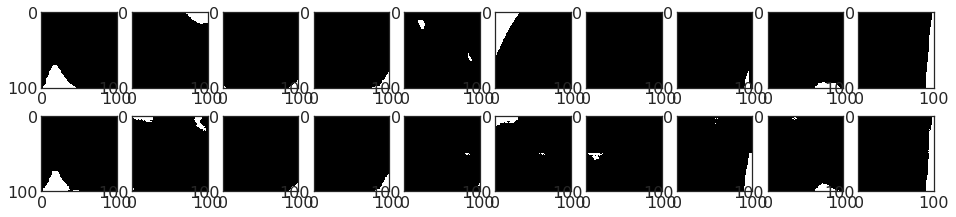

In [510]:
biginds = np.argwhere(val_coverage_category==1)

plt.figure(figsize=(16,3.5))
num_images = 10
for i in range(num_images):
    gt_mask = val_masks_orig[biginds[i]].squeeze()
    pred_mask  = preds_val_masks[biginds[i]].squeeze()
    
    plt.subplot(2,num_images,i+1); 
    plt.imshow(gt_mask, cmap='gray')
    
    plt.subplot(2,num_images,num_images + i + 1); 
    plt.imshow(pred_mask, cmap='gray')

In [511]:
val_images_orig.shape

(172, 101, 101)

In [524]:
non_zero_images = np.argwhere(val_images_orig.sum(axis=(1,2))>0)

In [523]:
non_zero_images

array([[  0],
       [  1],
       [  5],
       [  6],
       [ 10],
       [ 12],
       [ 13],
       [ 14],
       [ 17],
       [ 18],
       [ 20],
       [ 24],
       [ 25],
       [ 26],
       [ 27],
       [ 30],
       [ 33],
       [ 34],
       [ 35],
       [ 37],
       [ 39],
       [ 41],
       [ 42],
       [ 43],
       [ 48],
       [ 50],
       [ 51],
       [ 52],
       [ 54],
       [ 55],
       [ 56],
       [ 57],
       [ 58],
       [ 61],
       [ 63],
       [ 64],
       [ 66],
       [ 67],
       [ 68],
       [ 69],
       [ 73],
       [ 74],
       [ 77],
       [ 79],
       [ 83],
       [ 84],
       [ 90],
       [ 96],
       [ 98],
       [ 99],
       [100],
       [102],
       [109],
       [110],
       [111],
       [112],
       [116],
       [118],
       [121],
       [124],
       [125],
       [126],
       [127],
       [128],
       [129],
       [130],
       [131],
       [133],
       [134],
       [137],
       [139],
      

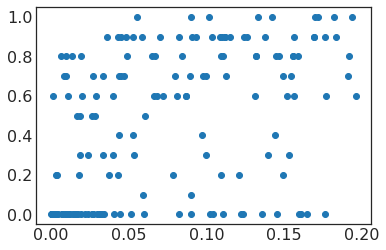

In [513]:
plt.plot(val_coverage[non_zero_images], APs[non_zero_images],'o')

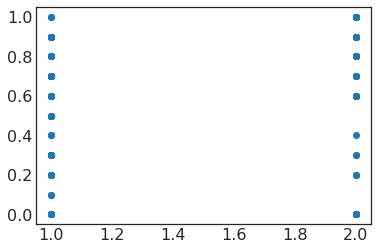

In [514]:
plt.plot(val_coverage_category[non_zero_images], APs[non_zero_images],'o')

In [515]:
np.array([val_coverage_category[non_zero_images], APs[non_zero_images]]).shape

(2, 172, 1)

In [516]:
def isvert(mask):
    mask = mask.squeeze()
    vertuni = np.unique(mask.sum(axis=1))
    vertlen = len(np.unique(mask.sum(axis=1)))
    if ((vertlen==1) and (vertuni[0]!=0) and (vertuni[0]!=101)):
        return True
    else:
        return False

In [525]:
cov_score = pd.DataFrame(np.array([non_zero_images, val_coverage[non_zero_images], val_coverage_category[non_zero_images], APs[non_zero_images]]).squeeze().T, columns=['imgind', 'cov', 'covcat','AP'])
cov_score['imgind'] = cov_score['imgind'].astype('int')
cov_score['pred_mask_coverage'] = cov_score['imgind'].map(lambda i: pred_to_binary_mask(preds_orig[i], threshold_max).sum() / area)
cov_score['isvert'] = cov_score['imgind'].map(lambda i: isvert(val_masks_orig[i]))

In [526]:
cov_score['isvert'].value_counts()

False    89
Name: isvert, dtype: int64

Let's see how we are doing by coverage category, mean score

In [528]:
cov_score.groupby(['covcat']).agg({'AP': ['count', np.mean, np.max, np.min]})['AP'].reset_index()

,covcat,count,mean,amax,amin
0,1.0,54,0.396296,1.0,0.0
1,2.0,35,0.620000,1.0,0.0


So we are doing pretty terribly on coverage category 1, 2, 3, so I believe that is up to 30%

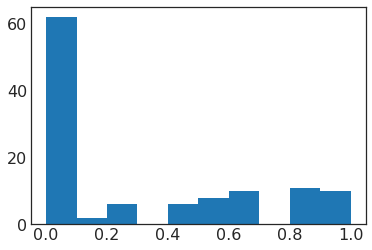

In [68]:
currdf = cov_score[cov_score['covcat']==1.0]
plt.hist(currdf['AP']); plt.show()

In [69]:
currdf = cov_score[(cov_score['covcat']==1.0) & (cov_score['AP'] <= 0.1)]

In [71]:
currdf.head()

,imgind,cov,covcat,AP,pred_mask_coverage
40,42,0.001568,1.0,0.0,0.000000
70,73,0.009999,1.0,0.0,0.000588
79,82,0.045388,1.0,0.0,0.018332
82,85,0.000392,1.0,0.0,0.000000
84,87,0.011469,1.0,0.0,0.014018


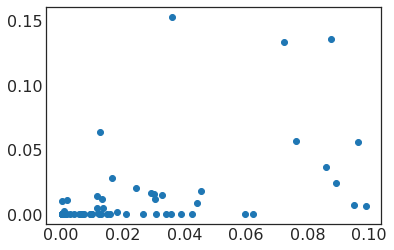

In [74]:
plt.plot(currdf['cov'], currdf['pred_mask_coverage'], 'o')

Let's take a look at the vertical barrier images

In [90]:
cov_score[cov_score['isvert']==True].sort_values('AP')

,imgind,cov,covcat,AP,pred_mask_coverage,isvert
14,14,0.544554,6.0,0.0,0.000000,True
653,670,0.603960,7.0,0.0,0.004215,True
616,633,0.118812,2.0,0.0,0.000000,True
603,620,0.465347,5.0,0.0,0.000000,True
589,605,0.881188,9.0,0.0,0.008529,True
536,550,0.594059,6.0,0.0,0.079796,True
531,545,0.554455,6.0,0.0,0.033330,True
507,521,0.831683,9.0,0.0,0.194981,True
456,470,0.089109,1.0,0.0,0.024213,True
411,422,0.128713,2.0,0.0,0.005294,True


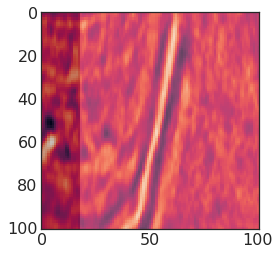

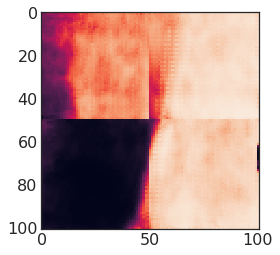

In [89]:
plt.imshow(val_images_orig[680]); plt.imshow(val_masks_orig[680].squeeze(), alpha=0.2); plt.show()
plt.imshow(preds_orig[680])

In [37]:
tta = TTA_ModelWrapper(model)
preds = tta.predict(val_images)

In [38]:
preds = preds.squeeze()

In [39]:
preds_orig = []
for i in range(len(val_images)//4):
    img1 = preds[4*i + 0]
    img2 = preds[4*i + 1]
    img3 = preds[4*i + 2]
    img4 = preds[4*i + 3]
    preds_orig.append(reassemble_chopped(img1, img2, img3, img4))
preds_orig = np.array(preds_orig)

In [41]:
val_orig_masks = val_masks_orig

In [44]:
preds_orig.shape, preds.shape

((800, 101, 101), (3200, 64, 64))

In [46]:
# Running on 10 images. Increase for better accuracy.
thresholds = np.linspace(0, 1.0, 50)
iou_thresholds = np.array([0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95])

mAPs = []
for threshold in tqdm_notebook(thresholds):
    APs = []
    for i in range(len(preds_orig)):
        image = val_images[i]
        ### Need this if/else if you eliminated samples with sum()==0
        if image.sum()==0:
            pred = np.zeros((101,101))
            mask = val_orig_masks[i].squeeze().astype(np.int8)

            AP = calc_avg_precision(pred, mask, threshold, iou_thresholds=iou_thresholds)
        else:
            pred = preds_orig[i]
            mask = val_orig_masks[i].squeeze().astype(np.int8)

            AP = calc_avg_precision(pred, mask, threshold, iou_thresholds=iou_thresholds)

        APs.append(AP)

    mAPs.append(np.mean(APs))

threshold_max_augmentation = thresholds[np.argmax(mAPs)]
mAP_max_augmentation = mAPs[np.argmax(mAPs)]

threshold_max_augmentation, mAP_max_augmentation

(0.7755102040816326, 0.731125)

In [64]:
iou_thresholds = np.array([0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95])
threshold = threshold_max_augmentation

APs = []
for i in range(len(preds_orig)):
    image = val_images[i]
    ### Need this if/else if you eliminated samples with sum()==0
    if image.sum()==0:
        pred = np.zeros((101,101))
        mask = val_orig_masks[i].squeeze().astype(np.int8)

        AP = calc_avg_precision(pred, mask, threshold, iou_thresholds=iou_thresholds)
    else:
        pred = preds_orig[i]
        mask = val_orig_masks[i].squeeze().astype(np.int8)

        AP = calc_avg_precision(pred, mask, threshold, iou_thresholds=iou_thresholds)

    APs.append(AP)

APs = np.array(APs)

In [65]:
non_zero_images = np.argwhere(val_images_orig.sum(axis=(1,2))!=0).squeeze()

In [66]:
def isvert(mask):
    mask = mask.squeeze()
    vertuni = np.unique(mask.sum(axis=1))
    vertlen = len(np.unique(mask.sum(axis=1)))
    if ((vertlen==1) and (vertuni[0]!=0) and (vertuni[0]!=101)):
        return True
    else:
        return False

In [67]:
cov_score = pd.DataFrame(np.array([non_zero_images, val_coverage[non_zero_images], val_coverage_category[non_zero_images], APs[non_zero_images]]).squeeze().T, columns=['imgind', 'cov', 'covcat','AP'])
cov_score['imgind'] = cov_score['imgind'].astype('int')
cov_score['pred_mask_coverage'] = cov_score['imgind'].map(lambda i: pred_to_binary_mask(preds_orig[i], threshold_max).sum() / area)
cov_score['isvert'] = cov_score['imgind'].map(lambda i: isvert(val_masks_orig[i]))

In [68]:
cov_score.groupby(['covcat']).agg({'AP': ['count', np.mean, np.max, np.min]})['AP']

,count,mean,amax,amin
covcat,,,,
0.0,295,0.901695,1.0,0.0
1.0,115,0.293043,1.0,0.0
2.0,59,0.581356,1.0,0.0
3.0,45,0.651111,1.0,0.0
4.0,37,0.832432,1.0,0.0
5.0,44,0.754545,1.0,0.0
6.0,41,0.770732,1.0,0.0
7.0,34,0.758824,1.0,0.0
8.0,30,0.780000,1.0,0.0


In [70]:
### Load in the whole list then eliminate those that are bad ###
testdir = '../../test/'
all_image_files = np.array(os.listdir(filter_directory_list(testdir + 'images/')))
good_test_images = all_image_files

### Load in the images ###
images_test_orig = np.array([load_image(testdir + 'images/' + x) for x in tqdm_notebook(good_test_images)])

### Use this for expansion trained models ###
# images_test = np.array([biggenate(x) for x in tqdm_notebook(images_test_orig)])

### Use this to mean center ###
images_test_orig = np.array([x - x.mean() for x in images_test_orig])

images_test = chop_up_images(images_test_orig)

# ### Use this for zero pad trained models ###
# images_test = np.array([biggenate_zero_pad(x) for x in tqdm_notebook(images_test_orig)])

In [71]:
preds_test = model.predict(images_test)

In [73]:
preds_test = preds_test.squeeze()

In [74]:
preds_test_orig = []
for i in range(len(images_test)//4):
    img1 = preds_test[4*i + 0]
    img2 = preds_test[4*i + 1]
    img3 = preds_test[4*i + 2]
    img4 = preds_test[4*i + 3]
    preds_test_orig.append(reassemble_chopped(img1, img2, img3, img4))
preds_test_orig = np.array(preds_test_orig)

In [75]:
# preds_test_masks = np.array([pred_to_binary_mask(x, thresholds[np.argmax(mAPs)]) for x in tqdm_notebook(preds_test_orig)])
preds_test_masks = np.array([pred_to_binary_mask(x, threshold_max) for x in tqdm_notebook(preds_test_orig)])

In [76]:
write_file = model_file + "_preds_test_masks"
np.save(write_file, preds_test_masks)

### Let's combine the two predictions

In [77]:
main_masks = np.load('./unet_models/unet_optimal_parameters_split_42_preds_test_masks.npy')
low_masks = np.load('./unet_models/unet_subdivide_images_1_preds_test_masks.npy')

In [82]:
main_masks.shape, low_masks.shape

((18000, 101, 101), (18000, 101, 101))

In [79]:
main_masks_coverage = main_masks.sum(axis=(1,2)) / area

(array([2411., 1235., 1042., 1015.,  958.,  859.,  786.,  687.,  694.,
         807.]),
 array([9.80296049e-05, 1.00078424e-01, 2.00058818e-01, 3.00039212e-01,
        4.00019606e-01, 5.00000000e-01, 5.99980394e-01, 6.99960788e-01,
        7.99941182e-01, 8.99921576e-01, 9.99901970e-01]),
 <a list of 10 Patch objects>)

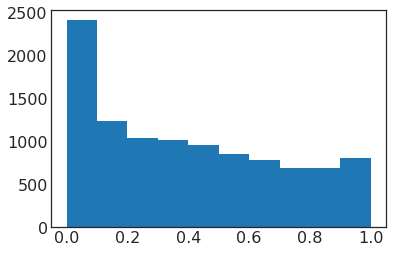

In [81]:
plt.hist(main_masks_coverage[main_masks_coverage!=0])

In [95]:
combined_masks = []
counter = 0
for i in range(len(main_masks)):
    if ((main_masks_coverage[i] > 0.0) and (main_masks_coverage[i] <= 0.1)):
        combined_masks.append(low_masks[i])
        counter += 1
#         print(i)
    else:
        combined_masks.append(main_masks[i])
combined_masks = np.array(combined_masks)

In [96]:
counter

2411

In [85]:
combined_masks.shape

(18000, 101, 101)

In [88]:
def mask_to_rle(mask):
    """Takes a mask that is nxm, represented as 0 and integers, or as Boolean,
    and converts it to run length encoding."""
    mask = np.transpose(mask)
    mask = mask.astype(np.bool).astype('int')
    mask = mask.reshape(-1)

    dummy = np.insert(mask, 0, 0)
    mask = np.insert(mask, len(mask), 0)

    diff = dummy - mask
    
    diffindx = np.argwhere(diff!=0)
    
    starts = diffindx[::2] + 1 # it is one indexed so need this
    
    runs = diffindx[1::2] - diffindx[::2]
    
    run_length_encoded = np.hstack((starts, runs)).reshape(-1)
    
    return run_length_encoded

In [102]:
submission_file = '../submissions/unet_combined_main_masks_only'

In [103]:
with(open(submission_file,'w')) as f:
    f.write('id,rle_mask')
    
    for i in tqdm_notebook(range(len(good_test_images))):
        image_name = good_test_images[i].split('.')[0]
        pred_mask = main_masks[i,:,:]
        if pred_mask.sum()==0:
            f.write('\n')
            f.write(image_name + ',')
        elif images_test_orig[i].sum()==0:
            f.write('\n')
            f.write(image_name + ',')
        else:
            pred_mask_rle = mask_to_rle(pred_mask)
            f.write('\n')
            f.write(image_name + ',' + ' '.join(list(pred_mask_rle.astype('str'))))

### Need to figure out how this compares on smaller pixelations: should i have a model that i use only for smaller predictions and another that I use for larger?

In [ ]:
# filter_scalings = [8, 16, 32]
# depths = [3, 4, 5, 6]
# depths = [5]
# filter_scalings = [64, 128]
# filter_scalings = [48]
# depths = [4, 5]
# batch_sizes = [32, 64, 128]
# batch_sizes = [64]
batch_norm_momentums = [0.8, 0.7, 0.6, 0.5]
number_folds = range(1,5)

filter_scaling = 48
depth = 5
batch_size = 64

record_file = "batch_norm_momentum_1.csv"
# if os.path.exists(record_file):
#     raise ValueError("Record file already exists")
    
# with(open(record_file,'w')) as f:
#     f.write('filter_scaling,depth,batchsize,fold,bn_momentum,highest_val_acc,lowest_val_loss,threshold_max,mAP_max,threshold_max_augmentation,mAP_max_augmentation')

# for filter_scaling in filter_scalings:
#     for depth in depths:
#         for batch_size in batch_sizes:
for batch_norm_momentum in batch_norm_momentums:
    for fold in number_folds:

        ##########################################################################################
        ###### Create the current train / test setups ###########################################
        ########################################################################################

        train_images, val_images, train_masks, val_masks, train_orig_masks, val_orig_masks, \
        train_image_files, val_image_files, train_indices, val_indices = train_test_split(images, masks, \
                                                                                    masks_orig, good_training_images, \
                                                                                    range(len(good_training_images)), \
                                                                                     stratify=coverage_category, \
                                                                                     test_size=0.2)

        ##########################################################################################
        ##### Create all generators #############################################################
        ########################################################################################

        generator_dict = {'horizontal_flip': True}

        image_datagen = ImageDataGenerator(**generator_dict)
        mask_datagen = ImageDataGenerator(**generator_dict)

        image_generator = image_datagen.flow(
                train_images,
                batch_size=batch_size,
                seed=1)

        mask_generator = mask_datagen.flow(
                train_masks,
                batch_size=batch_size,
                seed=1)

        combined_generator = zip(image_generator, mask_generator)

        ### Load the current model ###
        model = unet_model(filter_scaling=filter_scaling, depth=depth, batch_norm_momentum=batch_norm_momentum)

        ### Name the model ###
        model_file = "./unet_models/unet_optimal_parameters_m1_to_1_batch_norm_momentum_fs_" + str(filter_scaling) + \
                     "_d_" + str(depth) + "_bs_" + str(batch_size) + "_bn_" + str(batch_norm_momentum) + "_fold_" + str(fold)
        if os.path.exists(model_file):
            raise ValueError("Model file already exists")

        ### Set up model training parameters ###
        early_stopping = EarlyStopping(patience=12, verbose=1)
        model_checkpoint = ModelCheckpoint(model_file, save_best_only=True, verbose=1)
        reduce_lr = ReduceLROnPlateau(factor=0.2, patience=5, min_lr=1e-6, verbose=1)
        learning_rec= LearningRateHistory()

        ### Fit the model ###
        history = model.fit_generator(combined_generator, train_images.shape[0] // batch_size, \
                                      epochs=200, verbose=1, validation_data=(val_images, val_masks),
                                      callbacks=[early_stopping, model_checkpoint, reduce_lr, learning_rec])

        ### Load back in the best model ###
        model_to_load = model_file
        model.load_weights(model_to_load)

        ################################################################################
        ### Print out the history to file #############################################
        ##############################################################################
        df = pd.DataFrame()
        df['epoch'] = history.epoch
        df['loss'] = history.history['loss']
        df['acc'] = history.history['acc']
        df['val_loss'] = history.history['val_loss']
        df['val_acc'] = history.history['val_acc']
        df['lr'] = learning_rec.lr
        df.to_csv(model_file+'_history.csv',index=False)

        ###############################################################################
        ### Extract best parameters ##################################################
        #############################################################################
        highest_val_acc = history.history['val_acc'][np.argmax(history.history['val_acc'])]
        lowest_val_loss = history.history['val_loss'][np.argmin(history.history['val_loss'])]

        ###############################################################################
        ### Do prediction without augmentation #######################################
        #############################################################################

        preds = model.predict(val_images)

        ### Use this when working with zero padded images ###
        preds_orig = np.array([smallenate_zero_pad(x) for x in tqdm_notebook(preds.squeeze())])

        # Running on 10 images. Increase for better accuracy.
        thresholds = np.linspace(0, 1.0, 50)
        iou_thresholds = np.array([0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95])

        mAPs = []
        for threshold in tqdm_notebook(thresholds):
            APs = []
            for i in range(len(preds)):
                image = val_images[i]
                ### Need this if/else if you eliminated samples with sum()==0
                if image.sum()==0:
                    pred = np.zeros((101,101))
                    mask = val_orig_masks[i].squeeze().astype(np.int8)

                    AP = calc_avg_precision(pred, mask, threshold, iou_thresholds=iou_thresholds)
                else:
                    pred = preds_orig[i]
                    mask = val_orig_masks[i].squeeze().astype(np.int8)

                    AP = calc_avg_precision(pred, mask, threshold, iou_thresholds=iou_thresholds)

                APs.append(AP)

            mAPs.append(np.mean(APs))

        threshold_max = thresholds[np.argmax(mAPs)]
        mAP_max = mAPs[np.argmax(mAPs)]

        ###############################################################################
        ### Do prediction with augmentation ##########################################
        #############################################################################

        tta = TTA_ModelWrapper(model)
        preds = tta.predict(val_images)

        ### Use this when working with zero padded images ###
        preds_orig = np.array([smallenate_zero_pad(x) for x in tqdm_notebook(preds.squeeze())])

        # Running on 10 images. Increase for better accuracy.
        thresholds = np.linspace(0, 1.0, 50)
        iou_thresholds = np.array([0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95])

        mAPs = []
        for threshold in tqdm_notebook(thresholds):
            APs = []
            for i in range(len(preds)):
                image = val_images[i]
                ### Need this if/else if you eliminated samples with sum()==0
                if image.sum()==0:
                    pred = np.zeros((101,101))
                    mask = val_orig_masks[i].squeeze().astype(np.int8)

                    AP = calc_avg_precision(pred, mask, threshold, iou_thresholds=iou_thresholds)
                else:
                    pred = preds_orig[i]
                    mask = val_orig_masks[i].squeeze().astype(np.int8)

                    AP = calc_avg_precision(pred, mask, threshold, iou_thresholds=iou_thresholds)

                APs.append(AP)

            mAPs.append(np.mean(APs))

        threshold_max_augmentation = thresholds[np.argmax(mAPs)]
        mAP_max_augmentation = mAPs[np.argmax(mAPs)]

        #################################################################################################
        ##### Write the parameters out to file #########################################################
        ###############################################################################################

        output_vector = [filter_scaling,depth,batch_size,fold,batch_norm_momentum,highest_val_acc,lowest_val_loss] + \
                        [threshold_max,mAP_max,threshold_max_augmentation,mAP_max_augmentation]
        output_string = ','.join(list(np.array(output_vector).astype('str')))

        with(open(record_file,'a')) as f:
            f.write('\n')
            f.write(output_string)

Epoch 1/200
50/50 [==============================] - 37s 750ms/step - loss: 0.2655 - acc: 0.8859 - val_loss: 0.2069 - val_acc: 0.9241

Epoch 00001: val_loss improved from inf to 0.20690, saving model to ./unet_models/unet_optimal_parameters_m1_to_1_batch_norm_momentum_fs_48_d_5_bs_64_bn_0.8_fold_1
Epoch 2/200
50/50 [==============================] - 30s 600ms/step - loss: 0.1668 - acc: 0.9361 - val_loss: 0.1656 - val_acc: 0.9335

Epoch 00002: val_loss improved from 0.20690 to 0.16564, saving model to ./unet_models/unet_optimal_parameters_m1_to_1_batch_norm_momentum_fs_48_d_5_bs_64_bn_0.8_fold_1
Epoch 3/200
50/50 [==============================] - 30s 601ms/step - loss: 0.1497 - acc: 0.9440 - val_loss: 0.1576 - val_acc: 0.9411

Epoch 00003: val_loss improved from 0.16564 to 0.15761, saving model to ./unet_models/unet_optimal_parameters_m1_to_1_batch_norm_momentum_fs_48_d_5_bs_64_bn_0.8_fold_1
Epoch 4/200
50/50 [==============================] - 30s 602ms/step - loss: 0.1429 - acc: 0.945


Epoch 00037: val_loss did not improve
Epoch 38/200
50/50 [==============================] - 31s 614ms/step - loss: 0.0507 - acc: 0.9811 - val_loss: 0.2700 - val_acc: 0.9277

Epoch 00038: val_loss did not improve
Epoch 39/200
50/50 [==============================] - 31s 613ms/step - loss: 0.0523 - acc: 0.9804 - val_loss: 0.0965 - val_acc: 0.9685

Epoch 00039: val_loss did not improve

Epoch 00039: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 40/200
50/50 [==============================] - 31s 613ms/step - loss: 0.0408 - acc: 0.9844 - val_loss: 0.0855 - val_acc: 0.9718

Epoch 00040: val_loss did not improve
Epoch 41/200
50/50 [==============================] - 31s 616ms/step - loss: 0.0350 - acc: 0.9870 - val_loss: 0.0864 - val_acc: 0.9712

Epoch 00041: val_loss did not improve
Epoch 42/200
50/50 [==============================] - 31s 615ms/step - loss: 0.0327 - acc: 0.9875 - val_loss: 0.0923 - val_acc: 0.9702

Epoch 00042: val_loss did not improve
Epoch 43/


Epoch 1/200
50/50 [==============================] - 38s 754ms/step - loss: 0.2799 - acc: 0.8765 - val_loss: 0.2130 - val_acc: 0.9128

Epoch 00001: val_loss improved from inf to 0.21305, saving model to ./unet_models/unet_optimal_parameters_m1_to_1_batch_norm_momentum_fs_48_d_5_bs_64_bn_0.8_fold_2
Epoch 2/200
50/50 [==============================] - 30s 603ms/step - loss: 0.1812 - acc: 0.9290 - val_loss: 0.2395 - val_acc: 0.8963

Epoch 00002: val_loss did not improve
Epoch 3/200
50/50 [==============================] - 30s 608ms/step - loss: 0.1703 - acc: 0.9319 - val_loss: 0.2544 - val_acc: 0.8989

Epoch 00003: val_loss did not improve
Epoch 4/200
50/50 [==============================] - 31s 615ms/step - loss: 0.1583 - acc: 0.9392 - val_loss: 0.1594 - val_acc: 0.9405

Epoch 00004: val_loss improved from 0.21305 to 0.15939, saving model to ./unet_models/unet_optimal_parameters_m1_to_1_batch_norm_momentum_fs_48_d_5_bs_64_bn_0.8_fold_2
Epoch 5/200
50/50 [==============================] 


Epoch 1/200
50/50 [==============================] - 39s 774ms/step - loss: 0.2790 - acc: 0.8834 - val_loss: 0.1892 - val_acc: 0.9319

Epoch 00001: val_loss improved from inf to 0.18923, saving model to ./unet_models/unet_optimal_parameters_m1_to_1_batch_norm_momentum_fs_48_d_5_bs_64_bn_0.8_fold_3
Epoch 2/200
50/50 [==============================] - 30s 605ms/step - loss: 0.1864 - acc: 0.9298 - val_loss: 0.1664 - val_acc: 0.9345

Epoch 00002: val_loss improved from 0.18923 to 0.16637, saving model to ./unet_models/unet_optimal_parameters_m1_to_1_batch_norm_momentum_fs_48_d_5_bs_64_bn_0.8_fold_3
Epoch 3/200
50/50 [==============================] - 30s 606ms/step - loss: 0.1590 - acc: 0.9401 - val_loss: 0.1797 - val_acc: 0.9333

Epoch 00003: val_loss did not improve
Epoch 4/200
50/50 [==============================] - 31s 613ms/step - loss: 0.1521 - acc: 0.9407 - val_loss: 0.1924 - val_acc: 0.9269

Epoch 00004: val_loss did not improve
Epoch 5/200
50/50 [==============================] 


Epoch 1/200
50/50 [==============================] - 39s 772ms/step - loss: 0.2480 - acc: 0.9002 - val_loss: 0.2599 - val_acc: 0.8968

Epoch 00001: val_loss improved from inf to 0.25987, saving model to ./unet_models/unet_optimal_parameters_m1_to_1_batch_norm_momentum_fs_48_d_5_bs_64_bn_0.8_fold_4
Epoch 2/200
50/50 [==============================] - 30s 606ms/step - loss: 0.1772 - acc: 0.9315 - val_loss: 0.1562 - val_acc: 0.9409

Epoch 00002: val_loss improved from 0.25987 to 0.15619, saving model to ./unet_models/unet_optimal_parameters_m1_to_1_batch_norm_momentum_fs_48_d_5_bs_64_bn_0.8_fold_4
Epoch 3/200
50/50 [==============================] - 30s 607ms/step - loss: 0.1567 - acc: 0.9404 - val_loss: 0.1371 - val_acc: 0.9491

Epoch 00003: val_loss improved from 0.15619 to 0.13714, saving model to ./unet_models/unet_optimal_parameters_m1_to_1_batch_norm_momentum_fs_48_d_5_bs_64_bn_0.8_fold_4
Epoch 4/200
50/50 [==============================] - 31s 612ms/step - loss: 0.1486 - acc: 0.94

50/50 [==============================] - 31s 620ms/step - loss: 0.0454 - acc: 0.9825 - val_loss: 0.0756 - val_acc: 0.9721

Epoch 00037: val_loss did not improve
Epoch 00037: early stopping



Epoch 1/200
50/50 [==============================] - 39s 781ms/step - loss: 0.2570 - acc: 0.8932 - val_loss: 0.1771 - val_acc: 0.9361

Epoch 00001: val_loss improved from inf to 0.17709, saving model to ./unet_models/unet_optimal_parameters_m1_to_1_batch_norm_momentum_fs_48_d_5_bs_64_bn_0.7_fold_1
Epoch 2/200
50/50 [==============================] - 30s 606ms/step - loss: 0.1669 - acc: 0.9374 - val_loss: 0.1591 - val_acc: 0.9385

Epoch 00002: val_loss improved from 0.17709 to 0.15912, saving model to ./unet_models/unet_optimal_parameters_m1_to_1_batch_norm_momentum_fs_48_d_5_bs_64_bn_0.7_fold_1
Epoch 3/200
50/50 [==============================] - 30s 606ms/step - loss: 0.1532 - acc: 0.9420 - val_loss: 0.1614 - val_acc: 0.9361

Epoch 00003: val_loss did not improve
Epoch 4/200
50/50 [==============================] - 30s 609ms/step - loss: 0.1532 - acc: 0.9417 - val_loss: 0.2037 - val_acc: 0.9174

Epoch 00004: val_loss did not improve
Epoch 5/200
50/50 [==============================] 

50/50 [==============================] - 31s 618ms/step - loss: 0.0351 - acc: 0.9865 - val_loss: 0.0848 - val_acc: 0.9726

Epoch 00038: val_loss did not improve
Epoch 00038: early stopping



Epoch 1/200
50/50 [==============================] - 41s 829ms/step - loss: 0.2531 - acc: 0.8985 - val_loss: 0.2285 - val_acc: 0.9052

Epoch 00001: val_loss improved from inf to 0.22852, saving model to ./unet_models/unet_optimal_parameters_m1_to_1_batch_norm_momentum_fs_48_d_5_bs_64_bn_0.7_fold_2
Epoch 2/200
50/50 [==============================] - 30s 605ms/step - loss: 0.1799 - acc: 0.9303 - val_loss: 0.2299 - val_acc: 0.9234

Epoch 00002: val_loss did not improve
Epoch 3/200
50/50 [==============================] - 30s 607ms/step - loss: 0.1603 - acc: 0.9383 - val_loss: 0.1307 - val_acc: 0.9502

Epoch 00003: val_loss improved from 0.22852 to 0.13068, saving model to ./unet_models/unet_optimal_parameters_m1_to_1_batch_norm_momentum_fs_48_d_5_bs_64_bn_0.7_fold_2
Epoch 4/200
50/50 [==============================] - 30s 610ms/step - loss: 0.1479 - acc: 0.9424 - val_loss: 0.1282 - val_acc: 0.9542

Epoch 00004: val_loss improved from 0.13068 to 0.12815, saving model to ./unet_models/une

50/50 [==============================] - 31s 618ms/step - loss: 0.0375 - acc: 0.9857 - val_loss: 0.0882 - val_acc: 0.9730

Epoch 00038: val_loss did not improve
Epoch 39/200
50/50 [==============================] - 31s 620ms/step - loss: 0.0357 - acc: 0.9863 - val_loss: 0.0871 - val_acc: 0.9735

Epoch 00039: val_loss did not improve

Epoch 00039: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
Epoch 40/200
50/50 [==============================] - 31s 622ms/step - loss: 0.0320 - acc: 0.9877 - val_loss: 0.0902 - val_acc: 0.9726

Epoch 00040: val_loss did not improve
Epoch 41/200
50/50 [==============================] - 31s 621ms/step - loss: 0.0303 - acc: 0.9882 - val_loss: 0.0907 - val_acc: 0.9730

Epoch 00041: val_loss did not improve
Epoch 42/200
50/50 [==============================] - 31s 621ms/step - loss: 0.0306 - acc: 0.9883 - val_loss: 0.0932 - val_acc: 0.9725

Epoch 00042: val_loss did not improve
Epoch 43/200
50/50 [==============================] - 31s 618


Epoch 1/200
50/50 [==============================] - 41s 814ms/step - loss: 0.2825 - acc: 0.8759 - val_loss: 0.2056 - val_acc: 0.9194

Epoch 00001: val_loss improved from inf to 0.20558, saving model to ./unet_models/unet_optimal_parameters_m1_to_1_batch_norm_momentum_fs_48_d_5_bs_64_bn_0.7_fold_3
Epoch 2/200
50/50 [==============================] - 30s 605ms/step - loss: 0.1764 - acc: 0.9307 - val_loss: 0.1655 - val_acc: 0.9387

Epoch 00002: val_loss improved from 0.20558 to 0.16547, saving model to ./unet_models/unet_optimal_parameters_m1_to_1_batch_norm_momentum_fs_48_d_5_bs_64_bn_0.7_fold_3
Epoch 3/200
50/50 [==============================] - 30s 608ms/step - loss: 0.1600 - acc: 0.9376 - val_loss: 0.1708 - val_acc: 0.9301

Epoch 00003: val_loss did not improve
Epoch 4/200
50/50 [==============================] - 30s 610ms/step - loss: 0.1522 - acc: 0.9415 - val_loss: 0.1489 - val_acc: 0.9484

Epoch 00004: val_loss improved from 0.16547 to 0.14886, saving model to ./unet_models/une

50/50 [==============================] - 31s 620ms/step - loss: 0.0375 - acc: 0.9863 - val_loss: 0.0874 - val_acc: 0.9702

Epoch 00036: val_loss did not improve
Epoch 37/200
50/50 [==============================] - 31s 620ms/step - loss: 0.0372 - acc: 0.9863 - val_loss: 0.0864 - val_acc: 0.9700

Epoch 00037: val_loss did not improve
Epoch 38/200
50/50 [==============================] - 31s 620ms/step - loss: 0.0355 - acc: 0.9869 - val_loss: 0.0865 - val_acc: 0.9700

Epoch 00038: val_loss did not improve
Epoch 39/200
50/50 [==============================] - 31s 619ms/step - loss: 0.0372 - acc: 0.9861 - val_loss: 0.0914 - val_acc: 0.9703

Epoch 00039: val_loss did not improve

Epoch 00039: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
Epoch 40/200
50/50 [==============================] - 31s 618ms/step - loss: 0.0348 - acc: 0.9871 - val_loss: 0.0876 - val_acc: 0.9701

Epoch 00040: val_loss did not improve
Epoch 00040: early stopping



Epoch 1/200
50/50 [==============================] - 42s 832ms/step - loss: 0.2328 - acc: 0.9079 - val_loss: 0.3003 - val_acc: 0.9065

Epoch 00001: val_loss improved from inf to 0.30031, saving model to ./unet_models/unet_optimal_parameters_m1_to_1_batch_norm_momentum_fs_48_d_5_bs_64_bn_0.7_fold_4
Epoch 2/200
50/50 [==============================] - 30s 606ms/step - loss: 0.1672 - acc: 0.9356 - val_loss: 0.1600 - val_acc: 0.9424

Epoch 00002: val_loss improved from 0.30031 to 0.15996, saving model to ./unet_models/unet_optimal_parameters_m1_to_1_batch_norm_momentum_fs_48_d_5_bs_64_bn_0.7_fold_4
Epoch 3/200
50/50 [==============================] - 31s 611ms/step - loss: 0.1597 - acc: 0.9396 - val_loss: 0.1445 - val_acc: 0.9432

Epoch 00003: val_loss improved from 0.15996 to 0.14450, saving model to ./unet_models/unet_optimal_parameters_m1_to_1_batch_norm_momentum_fs_48_d_5_bs_64_bn_0.7_fold_4
Epoch 4/200
50/50 [==============================] - 31s 612ms/step - loss: 0.1323 - acc: 0.94


Epoch 00036: val_loss did not improve
Epoch 37/200
50/50 [==============================] - 31s 624ms/step - loss: 0.0337 - acc: 0.9874 - val_loss: 0.0910 - val_acc: 0.9709

Epoch 00037: val_loss did not improve
Epoch 38/200
50/50 [==============================] - 31s 624ms/step - loss: 0.0328 - acc: 0.9876 - val_loss: 0.0920 - val_acc: 0.9710

Epoch 00038: val_loss did not improve

Epoch 00038: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
Epoch 39/200
50/50 [==============================] - 31s 626ms/step - loss: 0.0319 - acc: 0.9878 - val_loss: 0.0921 - val_acc: 0.9709

Epoch 00039: val_loss did not improve
Epoch 00039: early stopping



Epoch 1/200
50/50 [==============================] - 45s 895ms/step - loss: 0.2409 - acc: 0.9069 - val_loss: 0.2209 - val_acc: 0.9064

Epoch 00001: val_loss improved from inf to 0.22091, saving model to ./unet_models/unet_optimal_parameters_m1_to_1_batch_norm_momentum_fs_48_d_5_bs_64_bn_0.6_fold_1
Epoch 2/200
50/50 [==============================] - 30s 607ms/step - loss: 0.1737 - acc: 0.9318 - val_loss: 0.2611 - val_acc: 0.9161

Epoch 00002: val_loss did not improve
Epoch 3/200
50/50 [==============================] - 30s 608ms/step - loss: 0.1603 - acc: 0.9405 - val_loss: 0.1440 - val_acc: 0.9480

Epoch 00003: val_loss improved from 0.22091 to 0.14401, saving model to ./unet_models/unet_optimal_parameters_m1_to_1_batch_norm_momentum_fs_48_d_5_bs_64_bn_0.6_fold_1
Epoch 4/200
50/50 [==============================] - 30s 609ms/step - loss: 0.1432 - acc: 0.9459 - val_loss: 0.2187 - val_acc: 0.9051

Epoch 00004: val_loss did not improve
Epoch 5/200
50/50 [==============================] 


Epoch 1/200
50/50 [==============================] - 44s 880ms/step - loss: 0.2484 - acc: 0.8995 - val_loss: 0.1736 - val_acc: 0.9346

Epoch 00001: val_loss improved from inf to 0.17358, saving model to ./unet_models/unet_optimal_parameters_m1_to_1_batch_norm_momentum_fs_48_d_5_bs_64_bn_0.6_fold_2
Epoch 2/200
50/50 [==============================] - 30s 607ms/step - loss: 0.1768 - acc: 0.9315 - val_loss: 0.3914 - val_acc: 0.9045

Epoch 00002: val_loss did not improve
Epoch 3/200
50/50 [==============================] - 30s 609ms/step - loss: 0.1591 - acc: 0.9385 - val_loss: 0.1476 - val_acc: 0.9427

Epoch 00003: val_loss improved from 0.17358 to 0.14757, saving model to ./unet_models/unet_optimal_parameters_m1_to_1_batch_norm_momentum_fs_48_d_5_bs_64_bn_0.6_fold_2
Epoch 4/200
50/50 [==============================] - 30s 610ms/step - loss: 0.1728 - acc: 0.9348 - val_loss: 0.1342 - val_acc: 0.9505

Epoch 00004: val_loss improved from 0.14757 to 0.13425, saving model to ./unet_models/une

Epoch 37/200
50/50 [==============================] - 31s 622ms/step - loss: 0.0372 - acc: 0.9856 - val_loss: 0.0762 - val_acc: 0.9741

Epoch 00037: val_loss did not improve
Epoch 38/200
50/50 [==============================] - 31s 623ms/step - loss: 0.0383 - acc: 0.9852 - val_loss: 0.0782 - val_acc: 0.9742

Epoch 00038: val_loss did not improve
Epoch 39/200
50/50 [==============================] - 31s 620ms/step - loss: 0.0348 - acc: 0.9866 - val_loss: 0.0819 - val_acc: 0.9722

Epoch 00039: val_loss did not improve
Epoch 40/200
50/50 [==============================] - 31s 623ms/step - loss: 0.0334 - acc: 0.9871 - val_loss: 0.0814 - val_acc: 0.9739

Epoch 00040: val_loss did not improve
Epoch 41/200
50/50 [==============================] - 31s 622ms/step - loss: 0.0320 - acc: 0.9878 - val_loss: 0.0831 - val_acc: 0.9756

Epoch 00041: val_loss did not improve
Epoch 42/200
50/50 [==============================] - 31s 623ms/step - loss: 0.0333 - acc: 0.9871 - val_loss: 0.0810 - val_acc: 0.


Epoch 1/200
50/50 [==============================] - 45s 900ms/step - loss: 0.2302 - acc: 0.9070 - val_loss: 0.2135 - val_acc: 0.9224

Epoch 00001: val_loss improved from inf to 0.21350, saving model to ./unet_models/unet_optimal_parameters_m1_to_1_batch_norm_momentum_fs_48_d_5_bs_64_bn_0.6_fold_3
Epoch 2/200
50/50 [==============================] - 30s 608ms/step - loss: 0.1704 - acc: 0.9357 - val_loss: 0.1635 - val_acc: 0.9389

Epoch 00002: val_loss improved from 0.21350 to 0.16353, saving model to ./unet_models/unet_optimal_parameters_m1_to_1_batch_norm_momentum_fs_48_d_5_bs_64_bn_0.6_fold_3
Epoch 3/200
50/50 [==============================] - 30s 609ms/step - loss: 0.1520 - acc: 0.9426 - val_loss: 0.1618 - val_acc: 0.9342

Epoch 00003: val_loss improved from 0.16353 to 0.16180, saving model to ./unet_models/unet_optimal_parameters_m1_to_1_batch_norm_momentum_fs_48_d_5_bs_64_bn_0.6_fold_3
Epoch 4/200
50/50 [==============================] - 30s 610ms/step - loss: 0.1393 - acc: 0.94

50/50 [==============================] - 31s 624ms/step - loss: 0.0352 - acc: 0.9868 - val_loss: 0.0920 - val_acc: 0.9720

Epoch 00035: val_loss did not improve
Epoch 36/200
50/50 [==============================] - 31s 622ms/step - loss: 0.0341 - acc: 0.9868 - val_loss: 0.0989 - val_acc: 0.9686

Epoch 00036: val_loss did not improve

Epoch 00036: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
Epoch 37/200
50/50 [==============================] - 31s 622ms/step - loss: 0.0324 - acc: 0.9879 - val_loss: 0.0947 - val_acc: 0.9704

Epoch 00037: val_loss did not improve
Epoch 38/200
50/50 [==============================] - 31s 623ms/step - loss: 0.0302 - acc: 0.9884 - val_loss: 0.0959 - val_acc: 0.9710

Epoch 00038: val_loss did not improve
Epoch 39/200
50/50 [==============================] - 31s 622ms/step - loss: 0.0297 - acc: 0.9888 - val_loss: 0.1011 - val_acc: 0.9699

Epoch 00039: val_loss did not improve
Epoch 40/200
50/50 [==============================] - 31s 619


Epoch 1/200
50/50 [==============================] - 46s 912ms/step - loss: 0.2759 - acc: 0.8859 - val_loss: 0.2243 - val_acc: 0.9072

Epoch 00001: val_loss improved from inf to 0.22431, saving model to ./unet_models/unet_optimal_parameters_m1_to_1_batch_norm_momentum_fs_48_d_5_bs_64_bn_0.6_fold_4
Epoch 2/200
50/50 [==============================] - 30s 608ms/step - loss: 0.1816 - acc: 0.9329 - val_loss: 0.1978 - val_acc: 0.9198

Epoch 00002: val_loss improved from 0.22431 to 0.19776, saving model to ./unet_models/unet_optimal_parameters_m1_to_1_batch_norm_momentum_fs_48_d_5_bs_64_bn_0.6_fold_4
Epoch 3/200
50/50 [==============================] - 31s 611ms/step - loss: 0.1587 - acc: 0.9409 - val_loss: 0.2073 - val_acc: 0.9330

Epoch 00003: val_loss did not improve
Epoch 4/200
50/50 [==============================] - 31s 611ms/step - loss: 0.1589 - acc: 0.9390 - val_loss: 0.1593 - val_acc: 0.9408

Epoch 00004: val_loss improved from 0.19776 to 0.15928, saving model to ./unet_models/une

50/50 [==============================] - 31s 623ms/step - loss: 0.0348 - acc: 0.9867 - val_loss: 0.0924 - val_acc: 0.9705

Epoch 00038: val_loss did not improve
Epoch 39/200
50/50 [==============================] - 31s 623ms/step - loss: 0.0320 - acc: 0.9876 - val_loss: 0.0986 - val_acc: 0.9702

Epoch 00039: val_loss did not improve
Epoch 40/200
50/50 [==============================] - 31s 623ms/step - loss: 0.0308 - acc: 0.9883 - val_loss: 0.0978 - val_acc: 0.9705

Epoch 00040: val_loss did not improve

Epoch 00040: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
Epoch 41/200
50/50 [==============================] - 31s 624ms/step - loss: 0.0296 - acc: 0.9885 - val_loss: 0.0954 - val_acc: 0.9717

Epoch 00041: val_loss did not improve
Epoch 42/200
50/50 [==============================] - 31s 623ms/step - loss: 0.0279 - acc: 0.9892 - val_loss: 0.1040 - val_acc: 0.9698

Epoch 00042: val_loss did not improve
Epoch 43/200
50/50 [==============================] - 31s 623


Epoch 1/200
50/50 [==============================] - 46s 929ms/step - loss: 0.2329 - acc: 0.9056 - val_loss: 0.2110 - val_acc: 0.9227

Epoch 00001: val_loss improved from inf to 0.21098, saving model to ./unet_models/unet_optimal_parameters_m1_to_1_batch_norm_momentum_fs_48_d_5_bs_64_bn_0.5_fold_1
Epoch 2/200
50/50 [==============================] - 30s 609ms/step - loss: 0.1634 - acc: 0.9372 - val_loss: 0.1431 - val_acc: 0.9462

Epoch 00002: val_loss improved from 0.21098 to 0.14305, saving model to ./unet_models/unet_optimal_parameters_m1_to_1_batch_norm_momentum_fs_48_d_5_bs_64_bn_0.5_fold_1
Epoch 3/200
50/50 [==============================] - 31s 610ms/step - loss: 0.1514 - acc: 0.9421 - val_loss: 0.1363 - val_acc: 0.9507

Epoch 00003: val_loss improved from 0.14305 to 0.13629, saving model to ./unet_models/unet_optimal_parameters_m1_to_1_batch_norm_momentum_fs_48_d_5_bs_64_bn_0.5_fold_1
Epoch 4/200
50/50 [==============================] - 31s 612ms/step - loss: 0.1393 - acc: 0.94

50/50 [==============================] - 31s 619ms/step - loss: 0.0316 - acc: 0.9879 - val_loss: 0.0864 - val_acc: 0.9716

Epoch 00036: val_loss did not improve
Epoch 00036: early stopping



Epoch 1/200
50/50 [==============================] - 50s 991ms/step - loss: 0.2938 - acc: 0.8749 - val_loss: 0.2137 - val_acc: 0.9175

Epoch 00001: val_loss improved from inf to 0.21369, saving model to ./unet_models/unet_optimal_parameters_m1_to_1_batch_norm_momentum_fs_48_d_5_bs_64_bn_0.5_fold_2
Epoch 2/200
50/50 [==============================] - 30s 608ms/step - loss: 0.1732 - acc: 0.9333 - val_loss: 0.2091 - val_acc: 0.9228

Epoch 00002: val_loss improved from 0.21369 to 0.20908, saving model to ./unet_models/unet_optimal_parameters_m1_to_1_batch_norm_momentum_fs_48_d_5_bs_64_bn_0.5_fold_2
Epoch 3/200
50/50 [==============================] - 31s 610ms/step - loss: 0.1544 - acc: 0.9419 - val_loss: 0.1692 - val_acc: 0.9325

Epoch 00003: val_loss improved from 0.20908 to 0.16919, saving model to ./unet_models/unet_optimal_parameters_m1_to_1_batch_norm_momentum_fs_48_d_5_bs_64_bn_0.5_fold_2
Epoch 4/200
50/50 [==============================] - 31s 611ms/step - loss: 0.1542 - acc: 0.94

### Create a submission

In [32]:
filter_scaling = 48
depth = 5
batch_size = 64
fold = 2
model = unet_model(filter_scaling=filter_scaling, depth=depth)
model_file = "./unet_models/unet_auto_param_search_fs_" + str(filter_scaling) + \
                         "_d_" + str(depth) + "_bs_" + str(batch_size) + "_fold_" + str(fold)

In [33]:
model_to_load = model_file
model.load_weights(model_to_load)
high_threshold = 0.673469

In [30]:
def mask_to_rle(mask):
    """Takes a mask that is nxm, represented as 0 and integers, or as Boolean,
    and converts it to run length encoding."""
    mask = np.transpose(mask)
    mask = mask.astype(np.bool).astype('int')
    mask = mask.reshape(-1)

    dummy = np.insert(mask, 0, 0)
    mask = np.insert(mask, len(mask), 0)

    diff = dummy - mask
    
    diffindx = np.argwhere(diff!=0)
    
    starts = diffindx[::2] + 1 # it is one indexed so need this
    
    runs = diffindx[1::2] - diffindx[::2]
    
    run_length_encoded = np.hstack((starts, runs)).reshape(-1)
    
    return run_length_encoded

In [31]:
### Load in the whole list then eliminate those that are bad ###
testdir = '../../test/'
all_image_files = np.array(os.listdir(filter_directory_list(testdir + 'images/')))
good_test_images = all_image_files

### Load in the images ###
images_test_orig = np.array([load_image(testdir + 'images/' + x) for x in tqdm_notebook(good_test_images)])

### Use this for expansion trained models ###
# images_test = np.array([biggenate(x) for x in tqdm_notebook(images_test_orig)])

### Use this to mean center ###
images_test_orig = np.array([x - x.mean() for x in images_test_orig])

### Use this for zero pad trained models ###
images_test = np.array([biggenate_zero_pad(x) for x in tqdm_notebook(images_test_orig)])

In [35]:
### Do the model predictions
tta = TTA_ModelWrapper(model)
preds_test = tta.predict(images_test)

# preds_test = model.predict(images_test)

### Use this for expansion trained models ###
# preds_test_orig = np.array([smallenate(x) for x in tqdm_notebook(preds_test.squeeze())])

### Use this for zero pad trained models ###
preds_test_orig = np.array([smallenate_zero_pad(x) for x in tqdm_notebook(preds_test.squeeze())])

# preds_test_masks = np.array([pred_to_binary_mask(x, thresholds[np.argmax(mAPs)]) for x in tqdm_notebook(preds_test_orig)])
preds_test_masks = np.array([pred_to_binary_mask(x, high_threshold) for x in tqdm_notebook(preds_test_orig)])

In [36]:
submission_file = '../submissions/' + model_file.split('/')[-1]#unet_preprocessing_3_submission'

In [37]:
with(open(submission_file,'w')) as f:
    f.write('id,rle_mask')
    
    for i in tqdm_notebook(range(len(good_test_images))):
        image_name = good_test_images[i].split('.')[0]
        pred_mask = preds_test_masks[i,:,:]
        if pred_mask.sum()==0:
            f.write('\n')
            f.write(image_name + ',')
        elif images_test_orig[i].sum()==0:
            f.write('\n')
            f.write(image_name + ',')
        else:
            pred_mask_rle = mask_to_rle(pred_mask)
            f.write('\n')
            f.write(image_name + ',' + ' '.join(list(pred_mask_rle.astype('str'))))

### After a significant amount of hyperparameter tuning, we aren't that far. Let's compare averaging the 4 fold models of the highest performing model, and also the single best 1 fold model of those same 4.

First let's load in the single best model and submit that.

In [44]:
model_file = "./unet_models/unet_optimal_parameters_m1_to_1_batch_norm_momentum_fs_48_d_5_bs_64_bn_0.6_fold_1"
model_to_load = model_file
model = unet_model(filter_scaling=48, depth=5, batch_norm_momentum=0.6)
model.load_weights(model_to_load)

high_threshold = 0.530612

### Do the model predictions
tta = TTA_ModelWrapper(model)
preds_test_1 = tta.predict(images_test)

In [38]:
model_file = "./unet_models/unet_optimal_parameters_m1_to_1_batch_norm_momentum_fs_48_d_5_bs_64_bn_0.6_fold_2"
model_to_load = model_file
model = unet_model(filter_scaling=48, depth=5, batch_norm_momentum=0.6)
model.load_weights(model_to_load)

high_threshold = 0.510204

### Do the model predictions
tta = TTA_ModelWrapper(model)
preds_test_2 = tta.predict(images_test)

In [43]:
preds_test_2 = preds_test

In [45]:
model_file = "./unet_models/unet_optimal_parameters_m1_to_1_batch_norm_momentum_fs_48_d_5_bs_64_bn_0.6_fold_3"
model_to_load = model_file
model = unet_model(filter_scaling=48, depth=5, batch_norm_momentum=0.6)
model.load_weights(model_to_load)

high_threshold = 0.530612

### Do the model predictions
tta = TTA_ModelWrapper(model)
preds_test_3 = tta.predict(images_test)

In [46]:
model_file = "./unet_models/unet_optimal_parameters_m1_to_1_batch_norm_momentum_fs_48_d_5_bs_64_bn_0.6_fold_4"
model_to_load = model_file
model = unet_model(filter_scaling=48, depth=5, batch_norm_momentum=0.6)
model.load_weights(model_to_load)

high_threshold = 0.448980

### Do the model predictions
tta = TTA_ModelWrapper(model)
preds_test_4 = tta.predict(images_test)

In [56]:
### Use this for zero pad trained models ###
preds_test_orig_1 = np.array([smallenate_zero_pad(x) for x in tqdm_notebook(preds_test_1.squeeze())])
preds_test_orig_2 = np.array([smallenate_zero_pad(x) for x in tqdm_notebook(preds_test_2.squeeze())])
preds_test_orig_3 = np.array([smallenate_zero_pad(x) for x in tqdm_notebook(preds_test_3.squeeze())])
preds_test_orig_4 = np.array([smallenate_zero_pad(x) for x in tqdm_notebook(preds_test_4.squeeze())])

# preds_test_masks = np.array([pred_to_binary_mask(x, thresholds[np.argmax(mAPs)]) for x in tqdm_notebook(preds_test_orig)])
high_threshold = 0.530612
preds_test_masks_1 = np.array([pred_to_binary_mask(x, high_threshold) for x in tqdm_notebook(preds_test_orig_1)])
high_threshold = 0.510204
preds_test_masks_2 = np.array([pred_to_binary_mask(x, high_threshold) for x in tqdm_notebook(preds_test_orig_2)])
high_threshold = 0.530612
preds_test_masks_3 = np.array([pred_to_binary_mask(x, high_threshold) for x in tqdm_notebook(preds_test_orig_3)])
high_threshold = 0.448980
preds_test_masks_4 = np.array([pred_to_binary_mask(x, high_threshold) for x in tqdm_notebook(preds_test_orig_4)])


In [57]:
preds_test_sum = preds_test_masks_1 + preds_test_masks_2 + preds_test_masks_3 + preds_test_masks_4

In [66]:
preds_test_masks = (preds_test_sum >= 3).astype(np.int8)

In [67]:
### Write out the actual submission file ###
submission_file = '../submissions/unet_optimal_parameters_m1_to_1_batch_norm_momentum_fs_48_d_5_bs_64_bn_0.6_all_folds_threshold_3'
write_submission_file(submission_file, preds_test_masks, good_test_images)

### Let's copy what he did, see if I can figure out what is going on with my training/test images. I think this is why it's not training up

In [77]:
import numpy as np
import pandas as pd

from random import randint

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split

from skimage.transform import resize

from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout

from tqdm import tqdm_notebook

In [57]:
img_size_ori = 101
img_size_target = 128

In [58]:
def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)
    #res = np.zeros((img_size_target, img_size_target), dtype=img.dtype)
    #res[:img_size_ori, :img_size_ori] = img
    #return res
    
def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)
    #return img[:img_size_ori, :img_size_ori]

In [3]:
train_df = pd.read_csv("../../train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv("../../depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

In [4]:
train_df["images"] = [np.array(load_img("../../train/images/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]

In [5]:
train_df["masks"] = [np.array(load_img("../../train/masks/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]

In [6]:
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)

In [7]:
def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
        
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)

/home/paperspace/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,0,'Coverage class')

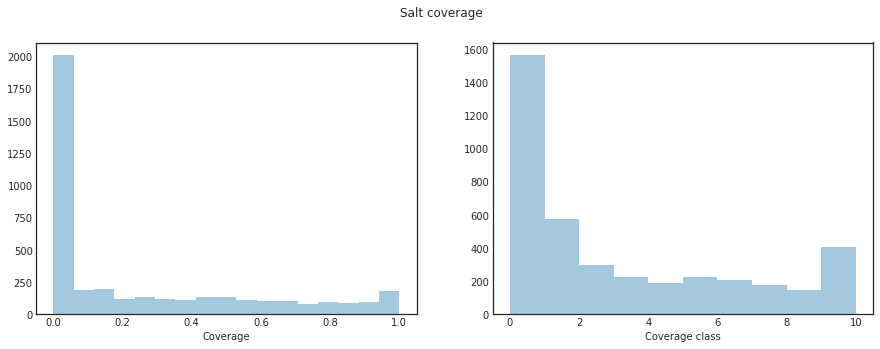

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.distplot(train_df.coverage, kde=False, ax=axs[0])
sns.distplot(train_df.coverage_class, bins=10, kde=False, ax=axs[1])
plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")

Text(0,0.5,'Coverage class')

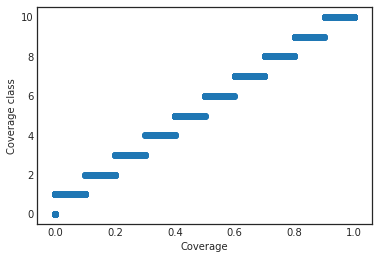

In [9]:
plt.scatter(train_df.coverage, train_df.coverage_class)
plt.xlabel("Coverage")
plt.ylabel("Coverage class")

/home/paperspace/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Depth distribution')

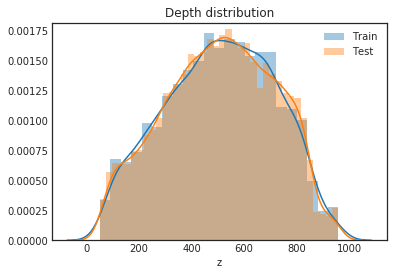

In [10]:
sns.distplot(train_df.z, label="Train")
sns.distplot(test_df.z, label="Test")
plt.legend()
plt.title("Depth distribution")

Text(0.5,0.98,'Green: salt. Top-left: coverage class, top-right: salt coverage, bottom-left: depth')

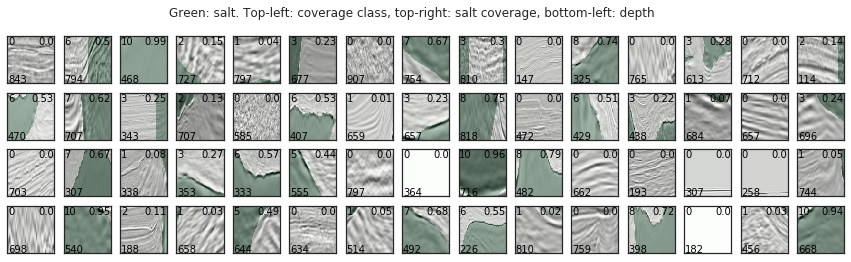

In [11]:
max_images = 60
grid_width = 15
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))
for i, idx in enumerate(train_df.index[:max_images]):
    img = train_df.loc[idx].images
    mask = train_df.loc[idx].masks
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(img, cmap="Greys")
    ax.imshow(mask, alpha=0.3, cmap="Greens")
    ax.text(1, img_size_ori-1, train_df.loc[idx].z, color="black")
    ax.text(img_size_ori - 1, 1, round(train_df.loc[idx].coverage, 2), color="black", ha="right", va="top")
    ax.text(1, 1, train_df.loc[idx].coverage_class, color="black", ha="left", va="top")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
plt.suptitle("Green: salt. Top-left: coverage class, top-right: salt coverage, bottom-left: depth")

In [12]:
ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = train_test_split(
    train_df.index.values,
    np.array(train_df.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    np.array(train_df.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    train_df.coverage.values,
    train_df.z.values,
    test_size=0.2, stratify=train_df.coverage_class, random_state=1337)

Text(0.5,1,'Scaled image')

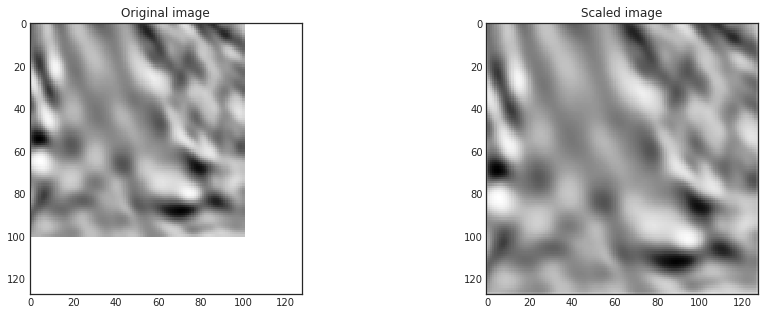

In [13]:
tmp_img = np.zeros((img_size_target, img_size_target), dtype=train_df.images.loc[ids_train[10]].dtype)
tmp_img[:img_size_ori, :img_size_ori] = train_df.images.loc[ids_train[10]]
fix, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].imshow(tmp_img, cmap="Greys")
axs[0].set_title("Original image")
axs[1].imshow(x_train[10].squeeze(), cmap="Greys")
axs[1].set_title("Scaled image")

In [80]:
def build_model(input_layer, start_neurons):
    # 128 -> 64
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    # 64 -> 32
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    # 32 -> 16
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    # 16 -> 8
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)

    # 8 -> 16
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    # 16 -> 32
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    # 32 -> 64
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    # 64 -> 128
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)

    #uconv1 = Dropout(0.5)(uconv1)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

input_layer = Input((img_size_target, img_size_target, 1))
output_layer = build_model(input_layer, 16)

model = Model(input_layer, output_layer)

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [83]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 128, 128, 16) 160         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 128, 128, 16) 2320        conv2d_20[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 64, 64, 16)   0           conv2d_21[0][0]                  
__________________________________________________________________________________________________
dropout_1 

In [72]:
batch_size = 32

history = model.fit(images, train_masks,
                    validation_data=[val_images, val_masks], 
                    epochs=20,
                    batch_size=batch_size)

# history = model.fit(x_train, y_train,
#                     validation_data=[x_valid, y_valid], 
#                     epochs=40,
#                     batch_size=batch_size)

Train on 3136 samples, validate on 784 samples
Epoch 1/40
3136/3136 [==============================] - 13s 4ms/step - loss: 0.5656 - acc: 0.7356 - val_loss: 0.5152 - val_acc: 0.7492
Epoch 2/40
3136/3136 [==============================] - 11s 4ms/step - loss: 0.4754 - acc: 0.7584 - val_loss: 0.4287 - val_acc: 0.7827
Epoch 3/40
3136/3136 [==============================] - 11s 3ms/step - loss: 0.4212 - acc: 0.8254 - val_loss: 0.3812 - val_acc: 0.8440
Epoch 4/40
3136/3136 [==============================] - 11s 3ms/step - loss: 0.3904 - acc: 0.8402 - val_loss: 0.3603 - val_acc: 0.8485
Epoch 5/40
3136/3136 [==============================] - 11s 3ms/step - loss: 0.3656 - acc: 0.8546 - val_loss: 0.3317 - val_acc: 0.8720
Epoch 6/40
3136/3136 [==============================] - 11s 4ms/step - loss: 0.3352 - acc: 0.8708 - val_loss: 0.3329 - val_acc: 0.8695
Epoch 7/40
3136/3136 [==============================] - 11s 4ms/step - loss: 0.3398 - acc: 0.8642 - val_loss: 0.3132 - val_acc: 0.8838
Epoch 8/

In [51]:
preds_valid = model.predict(x_valid).reshape(-1, img_size_target, img_size_target)
preds_valid = np.array([downsample(x) for x in preds_valid])
y_valid_ori = np.array([train_df.loc[idx].masks for idx in ids_valid])

In [59]:
preds_valid = model.predict(val_images).reshape(-1, 128, 128)
preds_valid = np.array([downsample(x) for x in preds_valid])
y_valid_ori = np.array([downsample(x) for x in val_masks])#np.array([train_df.loc[idx].masks for idx in ids_valid])

In [82]:
y_valid_ori.shape

(784, 101, 101, 1)

(array([9.802219e+06, 1.034700e+04, 9.064000e+03, 9.447000e+03,
        9.273000e+03, 8.913000e+03, 8.698000e+03, 9.123000e+03,
        1.093960e+05, 3.130720e+06]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

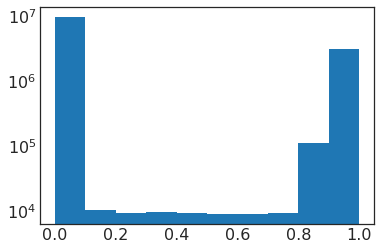

In [64]:
plt.hist(y_valid_ori.reshape(-1), log=True)

(array([6126474.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0., 2034326.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

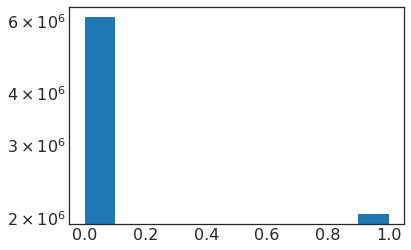

In [63]:
plt.hist(y_valid_ori.reshape(-1), log=True)

In [83]:
y_valid.dtype, y_valid_ori.dtype

(dtype('float64'), dtype('float64'))

In [60]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [76]:
# thresholds = np.linspace(0, 1, 50)
# ious = np.array([iou_metric_batch(y_valid_ori, np.int32(preds_valid > threshold)) for threshold in tqdm_notebook(thresholds)])

In [84]:
preds_valid.shape, y_valid_ori.shape

((784, 101, 101), (784, 101, 101, 1))

In [61]:
thresholds = np.linspace(0, 1, 50)
ious = np.array([iou_metric_batch(y_valid_ori.squeeze(), np.int32(preds_valid > threshold)) for threshold in tqdm_notebook(thresholds)])

In [62]:
threshold_best_index = np.argmax(ious[9:-10]) + 9
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

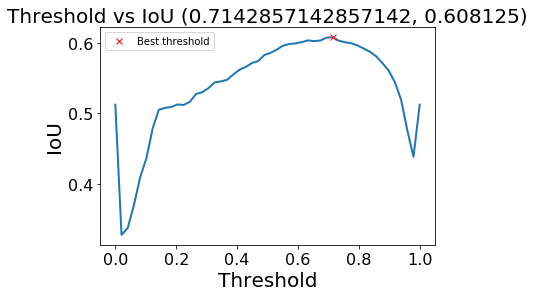

In [63]:
plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

In [19]:
%%time
preds = model.predict(x_valid)

CPU times: user 5.47 s, sys: 488 ms, total: 5.96 s
Wall time: 1.11 s


In [21]:
preds.shape

(800, 128, 128, 1)

In [22]:
preds = preds.squeeze()

In [23]:
preds.shape

(800, 128, 128)

In [24]:
y_valid.shape

(800, 128, 128, 1)

In [28]:
y_valid.dtype

dtype('float64')

In [29]:
np.unique(y_valid)

array([0.00000000e+00, 1.52587891e-05, 4.57763672e-05, ...,
       9.99984741e-01, 9.99984741e-01, 1.00000000e+00])

(array([9.802219e+06, 1.034700e+04, 9.064000e+03, 9.447000e+03,
        9.273000e+03, 8.913000e+03, 8.698000e+03, 9.123000e+03,
        1.093960e+05, 3.130720e+06]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

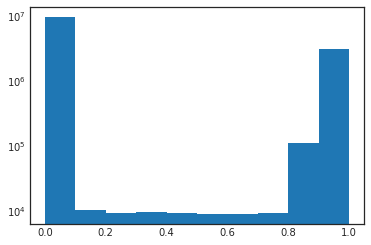

In [32]:
plt.hist(y_valid.reshape(-1), log=True)

In [90]:
# Running on 10 images. Increase for better accuracy.
thresholds = np.linspace(0, 1.0, 50)
iou_thresholds = np.array([0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95])

mAPs = []
for threshold in tqdm_notebook(thresholds):
    APs = []
    for i in range(len(preds_valid)):
        pred = preds_valid[i]
        mask = y_valid_ori[i].squeeze().astype(np.int8)

        AP = calc_avg_precision(pred, mask, threshold, iou_thresholds=iou_thresholds)
    #     if (mask.sum()==0) and (pred.sum()==0):
    #         AP = 1.0
    #     elif (mask.sum()==0) and (pred.sum()!=0):
    #         AP = 0.0
    #     else:
    #     AP = calc_iou(pred, mask, 0.2)

        APs.append(AP)
    #         precs.append(precisions)
    mAPs.append(np.mean(APs))

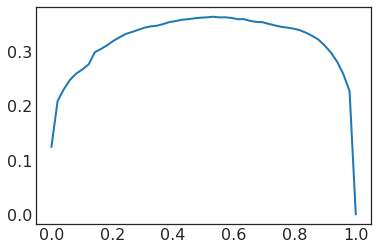

In [91]:
plt.plot(thresholds, mAPs)

In [91]:
x_train.shape, y_train.shape

((3200, 128, 128, 1), (3200, 128, 128, 1))

In [92]:
train_images.shape, train_masks.shape

(3136, 128, 128, 1)

In [94]:
x_train.max()

1.0

In [95]:
x_train.min()

0.0

(array([ 1219722.,   953500.,  3979355., 10483119., 13961241., 11500404.,
         6833755.,  2582119.,   679858.,   235727.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

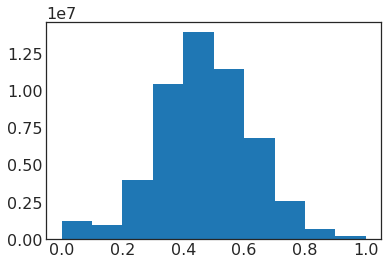

In [97]:
plt.hist(x_train.reshape(-1))

In [99]:
y_train.max(), y_train.min()

(1.0, 0.0)

(array([3.9298886e+07, 4.0603000e+04, 3.5761000e+04, 3.5707000e+04,
        3.5299000e+04, 3.3754000e+04, 3.6626000e+04, 3.5644000e+04,
        4.3894400e+05, 1.2437576e+07]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

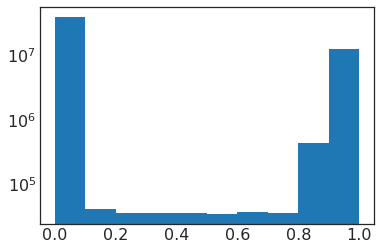

In [58]:
plt.hist(y_train.reshape(-1), log=True)

(array([38606379.,        0.,        0.,        0.,        0.,        0.,
               0.,        0.,        0., 12773845.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

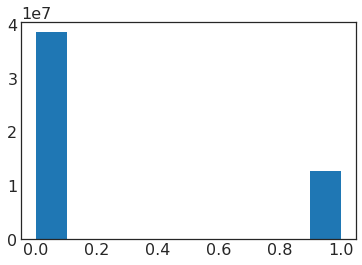

In [101]:
plt.hist(train_masks.reshape(-1))